In [1]:
library(rethinking)
## R code 6.1
sppnames <- c( "afarensis","africanus","habilis","boisei",
    "rudolfensis","ergaster","sapiens")
brainvolcc <- c( 438 , 452 , 612, 521, 752, 871, 1350 )
masskg <- c( 37.0 , 35.5 , 34.5 , 41.5 , 55.5 , 61.0 , 53.5 )
d <- data.frame( species=sppnames , brain=brainvolcc , mass=masskg )

Loading required package: rstan
Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
Loading required package: parallel
rethinking (Version 1.58)


In [2]:
## R code 6.2
m6.1 <- lm( brain ~ mass , data=d )

In [3]:
## R code 6.3
1 - var(resid(m6.1))/var(d$brain)

[1] 0.490158

In [4]:
## R code 6.4
m6.2 <- lm( brain ~ mass + I(mass^2) , data=d )

In [5]:
## R code 6.5
m6.3 <- lm( brain ~ mass + I(mass^2) + I(mass^3) , data=d )
m6.4 <- lm( brain ~ mass + I(mass^2) + I(mass^3) + I(mass^4) ,
    data=d )
m6.5 <- lm( brain ~ mass + I(mass^2) + I(mass^3) + I(mass^4) +
    I(mass^5) , data=d )
m6.6 <- lm( brain ~ mass + I(mass^2) + I(mass^3) + I(mass^4) +
    I(mass^5) + I(mass^6) , data=d )

In [6]:
## R code 6.6
m6.7 <- lm( brain ~ 1 , data=d )

In [7]:
## R code 6.7
i=3
d.new <- d[ -i , ]

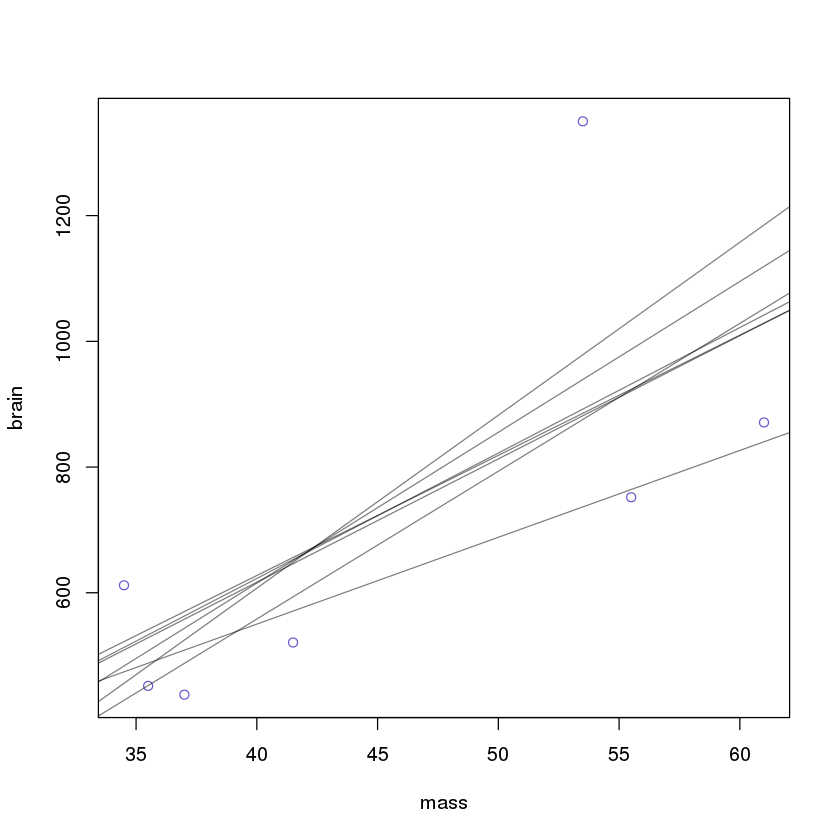

In [8]:
## R code 6.8
plot( brain ~ mass , d , col="slateblue" )
for ( i in 1:nrow(d) ) {
    d.new <- d[ -i , ]
    m0 <- lm( brain ~ mass, d.new )
    abline( m0 , col=col.alpha("black",0.5) )
}

In [9]:
## R code 6.9
p <- c( 0.3 , 0.7 )
-sum( p*log(p) )

[1] 0.6108643

In [10]:
## R code 6.10
# fit model with lm
m6.1 <- lm( brain ~ mass , d )

# compute deviance by cheating
(-2) * logLik(m6.1)

'log Lik.' 94.92499 (df=3)

In [11]:
## R code 6.11
# standardize the mass before fitting
d$mass.s <- (d$mass-mean(d$mass))/sd(d$mass)
m6.8 <- map(
    alist(
        brain ~ dnorm( mu , sigma ) ,
        mu <- a + b*mass.s
    ) ,
    data=d ,
    start=list(a=mean(d$brain),b=0,sigma=sd(d$brain)) ,
    method="Nelder-Mead" )

# extract MAP estimates
theta <- coef(m6.8)

# compute deviance
dev <- (-2)*sum( dnorm(
            d$brain ,
            mean=theta[1]+theta[2]*d$mass.s ,
            sd=theta[3] ,
            log=TRUE ) )
dev

[1] 94.92499

In [12]:
## R code 6.12
N <- 20
kseq <- 1:5
dev <- sapply( kseq , function(k) {
        print(k);
        r <- replicate( 1e4 , sim.train.test( N=N, k=k ) );
        c( mean(r[1,]) , mean(r[2,]) , sd(r[1,]) , sd(r[2,]) )
    } )

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


In [13]:
## R code 6.13
#        r <- mcreplicate( 1e4 , sim.train.test( N=N, k=k ) , mc.cores=4 )

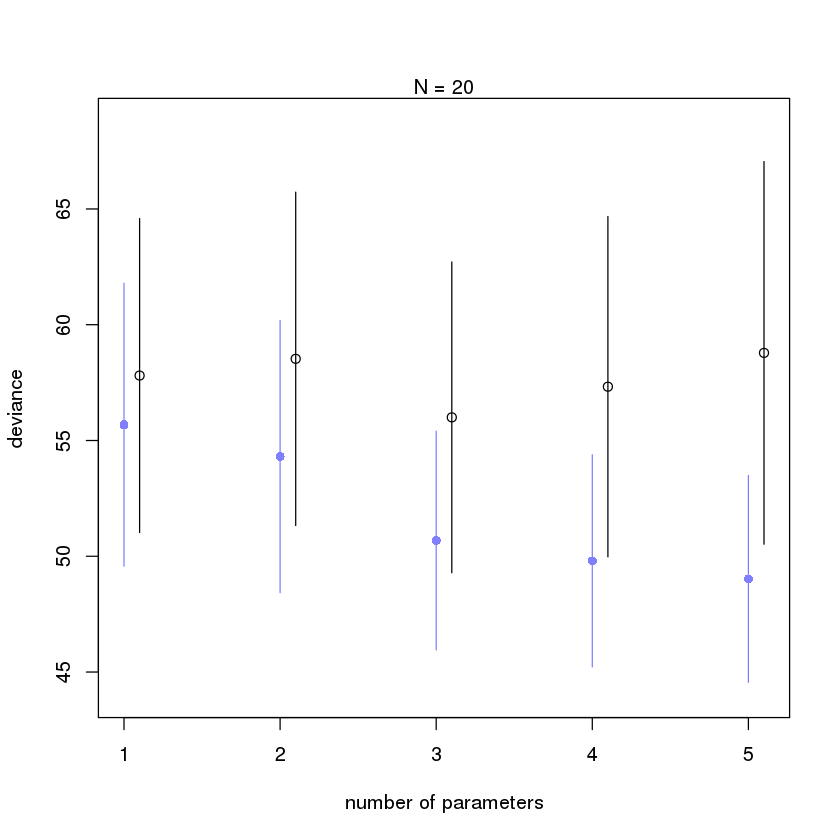

In [14]:
## R code 6.14
plot( 1:5 , dev[1,] , ylim=c( min(dev[1:2,])-5 , max(dev[1:2,])+10 ) ,
    xlim=c(1,5.1) , xlab="number of parameters" , ylab="deviance" ,
    pch=16 , col=rangi2 )
mtext( concat( "N = ",N ) )
points( (1:5)+0.1 , dev[2,] )
for ( i in kseq ) {
    pts_in <- dev[1,i] + c(-1,+1)*dev[3,i]
    pts_out <- dev[2,i] + c(-1,+1)*dev[4,i]
    lines( c(i,i) , pts_in , col=rangi2 )
    lines( c(i,i)+0.1 , pts_out )
}

In [15]:
## R code 6.15
data(cars)
m <- map(
    alist(
        dist ~ dnorm(mu,sigma),
        mu <- a + b*speed,
        a ~ dnorm(0,100),
        b ~ dnorm(0,10),
        sigma ~ dunif(0,30)
    ) , data=cars )
post <- extract.samples(m,n=1000)

In [16]:
## R code 6.16
n_samples <- 1000
ll <- sapply( 1:n_samples ,
    function(s) {
        mu <- post$a[s] + post$b[s]*cars$speed
        dnorm( cars$dist , mu , post$sigma[s] , log=TRUE )
    } )

In [17]:
## R code 6.17
n_cases <- nrow(cars)
lppd <- sapply( 1:n_cases , function(i) log_sum_exp(ll[i,]) - log(n_samples) )

In [18]:
## R code 6.18
pWAIC <- sapply( 1:n_cases , function(i) var(ll[i,]) )

In [19]:
## R code 6.19
-2*( sum(lppd) - sum(pWAIC) )

[1] 420.9498

In [20]:
## R code 6.20
waic_vec <- -2*( lppd - pWAIC )
sqrt( n_cases*var(waic_vec) )

[1] 14.33877

In [21]:
## R code 6.21
data(milk)
d <- milk[ complete.cases(milk) , ]
d$neocortex <- d$neocortex.perc / 100
dim(d)

[1] 17  9

In [22]:
## R code 6.22
a.start <- mean(d$kcal.per.g)
sigma.start <- log(sd(d$kcal.per.g))
m6.11 <- map(
    alist(
        kcal.per.g ~ dnorm( a , exp(log.sigma) )
    ) ,
    data=d , start=list(a=a.start,log.sigma=sigma.start) )
m6.12 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , exp(log.sigma) ) ,
        mu <- a + bn*neocortex
    ) ,
    data=d , start=list(a=a.start,bn=0,log.sigma=sigma.start) )
m6.13 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , exp(log.sigma) ) ,
        mu <- a + bm*log(mass)
    ) ,
    data=d , start=list(a=a.start,bm=0,log.sigma=sigma.start) )
m6.14 <- map(
    alist(
        kcal.per.g ~ dnorm( mu , exp(log.sigma) ) ,
        mu <- a + bn*neocortex + bm*log(mass)
    ) ,
    data=d , start=list(a=a.start,bn=0,bm=0,log.sigma=sigma.start) )

In [23]:
## R code 6.23
WAIC( m6.14 )

Constructing posterior predictions


[ 1000 / 1000 ]


[1] -14.88242
attr(,"lppd")
[1] 12.32853
attr(,"pWAIC")
[1] 4.887316
attr(,"se")
[1] 7.552332

In [24]:
## R code 6.24
( milk.models <- compare( m6.11 , m6.12 , m6.13 , m6.14 ) )

       WAIC pWAIC dWAIC weight   SE  dSE
m6.14 -15.4   4.6   0.0   0.95 7.52   NA
m6.13  -7.7   3.1   7.7   0.02 5.76 4.99
m6.11  -7.7   2.1   7.7   0.02 4.68 7.21
m6.12  -6.5   2.8   8.9   0.01 4.19 7.38

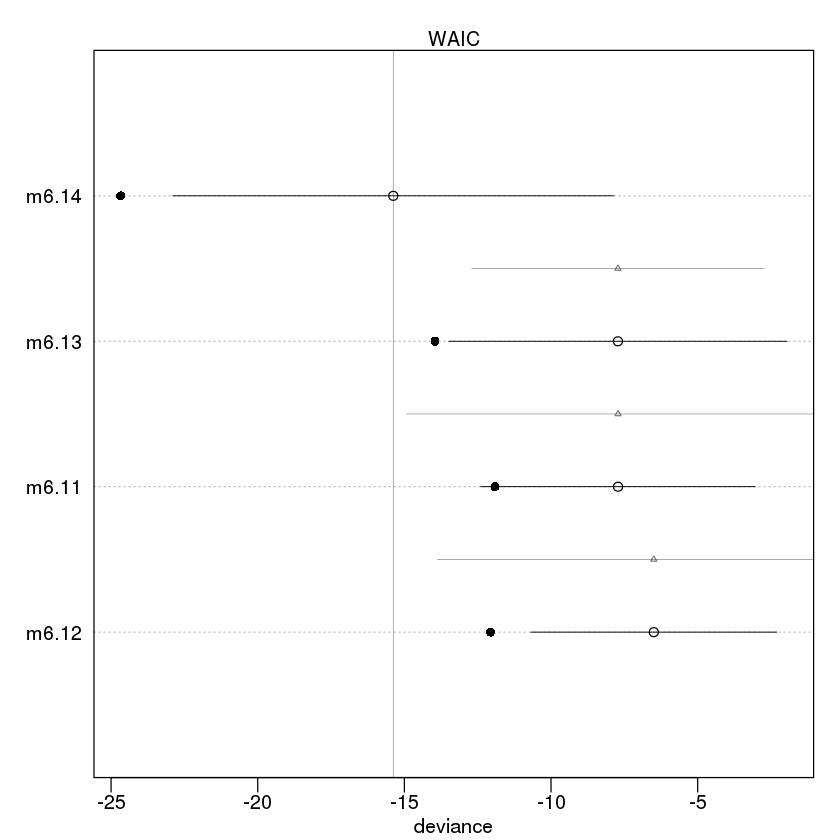

In [25]:
## R code 6.25
plot( milk.models , SE=TRUE , dSE=TRUE )

In [26]:
## R code 6.26
diff <- rnorm( 1e5 , 6.7 , 7.26 )
sum(diff<0)/1e5

[1] 0.18001

In [27]:
## R code 6.27
coeftab(m6.11,m6.12,m6.13,m6.14)

          m6.11   m6.12   m6.13   m6.14  
a            0.66    0.35    0.71   -1.09
log.sigma   -1.79   -1.80   -1.85   -2.16
bn             NA    0.45      NA    2.79
bm             NA      NA   -0.03   -0.10
nobs           17      17      17      17

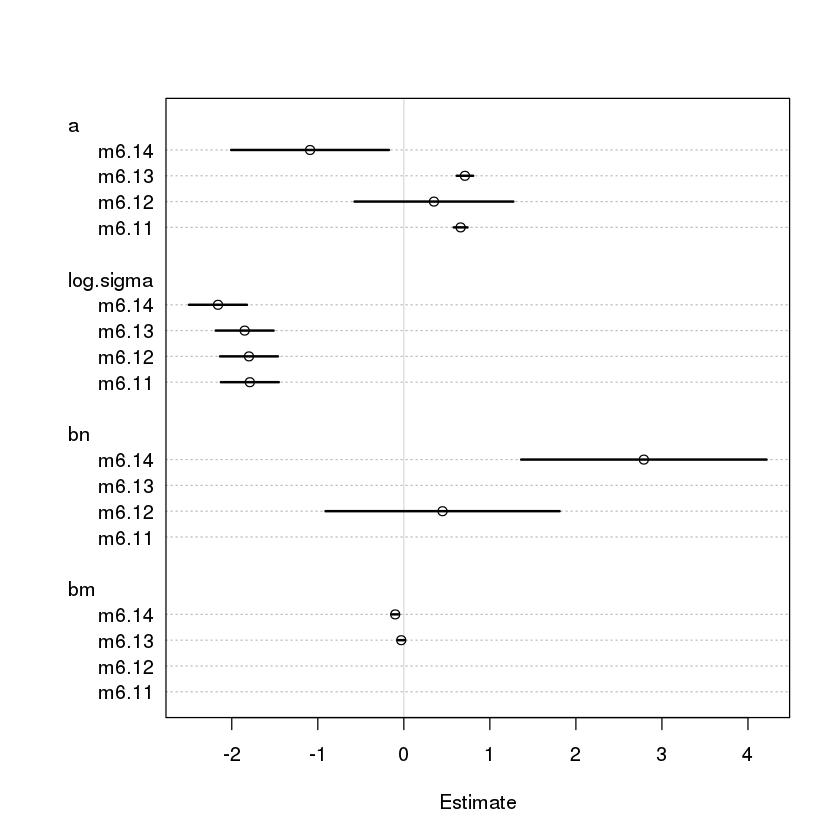

In [28]:
## R code 6.28
plot( coeftab(m6.11,m6.12,m6.13,m6.14) )

[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


Constructing posterior predictions


[ 1000 / 1000 ]


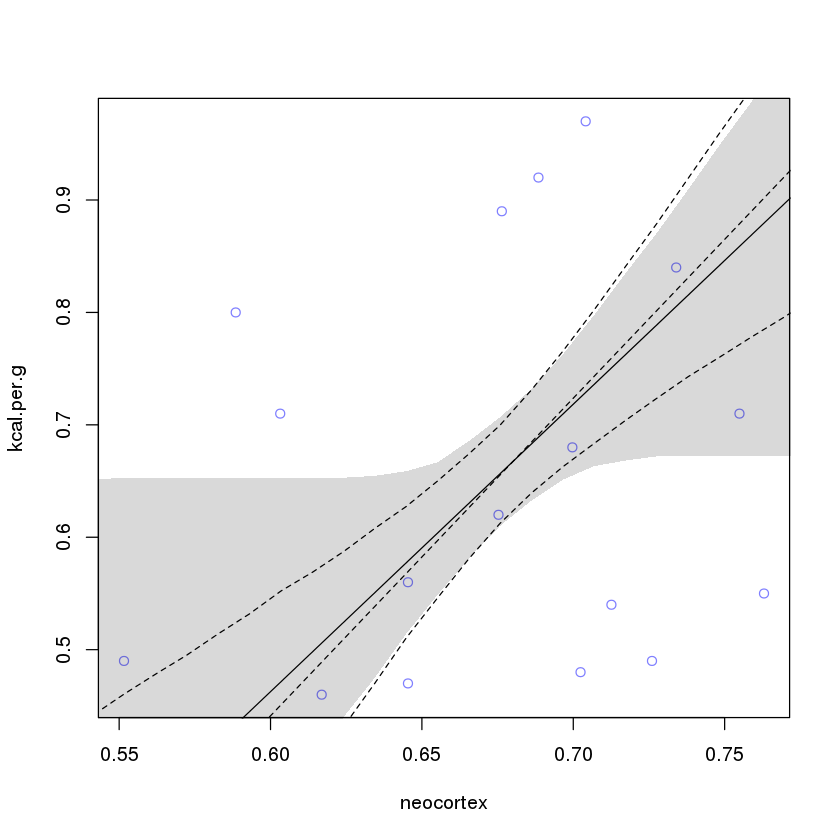

In [29]:
## R code 6.29
# compute counterfactual predictions
# neocortex from 0.5 to 0.8
nc.seq <- seq(from=0.5,to=0.8,length.out=30)
d.predict <- list(
    kcal.per.g = rep(0,30), # empty outcome
    neocortex = nc.seq,     # sequence of neocortex
    mass = rep(4.5,30)      # average mass
)
pred.m6.14 <- link( m6.14 , data=d.predict )
mu <- apply( pred.m6.14 , 2 , mean )
mu.PI <- apply( pred.m6.14 , 2 , PI )

# plot it all
plot( kcal.per.g ~ neocortex , d , col=rangi2 )
lines( nc.seq , mu , lty=2 )
lines( nc.seq , mu.PI[1,] , lty=2 )
lines( nc.seq , mu.PI[2,] , lty=2 )

## R code 6.30
milk.ensemble <- ensemble( m6.11 , m6.12 , m6.13 , m6.14 , data=d.predict )
mu <- apply( milk.ensemble$link , 2 , mean )
mu.PI <- apply( milk.ensemble$link , 2 , PI )
lines( nc.seq , mu )
shade( mu.PI , nc.seq )

In [30]:
## R code 6.31
library(rethinking)
data(Howell1)
d <- Howell1
d$age <- (d$age - mean(d$age))/sd(d$age)
set.seed( 1000 )
i <- sample(1:nrow(d),size=nrow(d)/2)
d1 <- d[ i , ]
d2 <- d[ -i , ]

In [31]:
## R code 6.32
sum( dnorm( d2$height , mu , sigma , log=TRUE ) )

ERROR: Error in dnorm(d2$height, mu, sigma, log = TRUE): object 'sigma' not found
